# **Model Selection**



In [134]:
#import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.model_selection import GridSearchCV
import pickle

## **Load the Data**

**NOTE :-** We have loaded the data from the feature-selection notebook.

- **We want to create a scikit-learn pipeline that will handle all the steps needed to prepare the data and build the model. This includes changing categorical data to numerical data, applying encoding techniques, and building the model etc.** 

- **By using this pipeline, we don't need to save the data after each step, making the process simpler and more efficient.** 

In [135]:
input = '../data/clean-data/flats-house-cleaned-v6.csv'

df = pd.read_csv(input)

print("Shape of the data : ",df.shape)
df.head()

Shape of the data :  (3540, 13)


,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 77,1.50,3,3,3,Relatively New,1310.0,0,0,2,Medium,Mid Floor
1,flat,sector 108,0.85,3,3,2,Relatively New,1500.0,1,0,0,Medium,Low Floor
2,flat,sector 12,0.60,2,2,1,New Property,800.0,0,0,1,Low,Low Floor
3,flat,sector 99a,0.30,2,1,0,New Property,500.0,0,0,0,Low,High Floor
4,flat,sector 102,1.55,3,4,3,Relatively New,1315.0,1,0,2,High,Mid Floor


In [136]:
# furnishing_type column has 3 categories
df['furnishing_type'].value_counts()

furnishing_type
0    2368
2     987
1     185
Name: count, dtype: int64

- 0 -> unfurnished

- 1 -> semifurnished

- 2 -> furnished

In [137]:

# converting furnishing_type column to categorical
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished',1.0:'semifurnished',2.0:'furnished'})
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 77,1.50,3,3,3,Relatively New,1310.0,0,0,furnished,Medium,Mid Floor
1,flat,sector 108,0.85,3,3,2,Relatively New,1500.0,1,0,unfurnished,Medium,Low Floor
2,flat,sector 12,0.60,2,2,1,New Property,800.0,0,0,semifurnished,Low,Low Floor
3,flat,sector 99a,0.30,2,1,0,New Property,500.0,0,0,unfurnished,Low,High Floor
4,flat,sector 102,1.55,3,4,3,Relatively New,1315.0,1,0,furnished,High,Mid Floor


---

## **Outline** :

- We will use three techniques to encode the categorical variables and then we will compare R2-scores.

1. `Ordinal Encoding` : [ Works well with tree based models ]

2. `OneHotEncoding` : [ Works well with linear models ]

3. `Target Encoding` : [ Works well with tree based models ]

- The encoding technique which gives the best R2-score , We will use that encoding technique to build the model.

In [72]:
X = df.drop(columns=['price'])
y = df['price']

# Since  price have skewed distribtuion , we need to apply the log1p transformation to it
y_transformed = np.log1p(y)

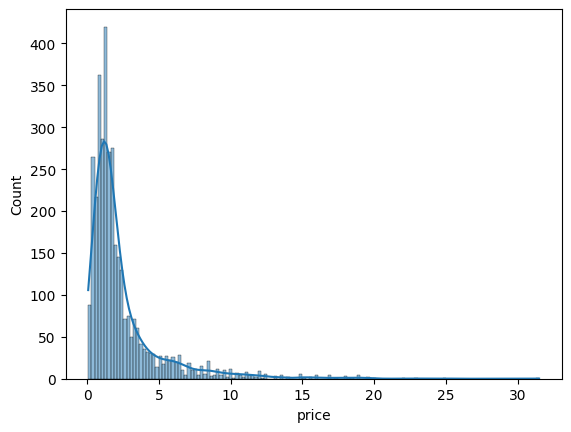

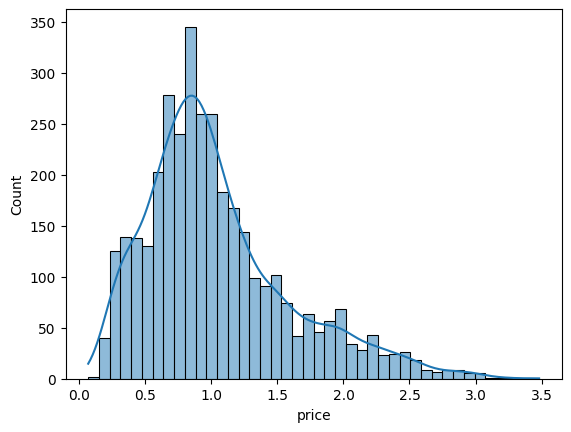

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y,kde=True)
plt.show()

sns.histplot(y_transformed,kde=True)
plt.show()

### **1 .Ordinal Encoding**

In [43]:
# Standard Scaling to Numerical columns
numerical_columns = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']


# List of columns that need to be encoded
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Create a column transformer for preprocessing
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode)
    ], 
    remainder='passthrough'  # Keep other columns as they are
)

# Create a pipeline with preprocessing and linear regression
pipeline1 = Pipeline([
    ('preprocessor1', preprocessor1),
    ('regressor', LinearRegression())
])
pipeline1

Pipeline(steps=[('preprocessor1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('regressor', LinearRegression())])

In [44]:
# We will train & evaluate the model using K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores1 = cross_val_score(pipeline1, X, y_transformed, cv=kfold, scoring='r2')

print("\n\n***** With Ordinal Encoding : *****")
print("  Mean of R2-score : ",scores1.mean())
print("  std of R2-score :  ",scores1.std())



***** With Ordinal Encoding : *****
  Mean of R2-score :  0.7358613112250211
  std of R2-score :   0.02594730292611873


- **Observation :- On average, Using `Ordinal Encoding` our Linear Regression  model is giving R2-Score of 73.58 . Which is not good.**


- **Now , We also want to test  `Mean Absolute Error` because we are doing a predictive task. Along with  R2-Score,We also want to check MAE of our Model**

In [45]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

# Fitting the pipeline on the training data
pipeline1.fit(X_train,y_train)

# Predicting the target variable for the test set
y_pred = pipeline1.predict(X_test)


# Applying the inverse of the log1p transformation to the predictions using expm1
# expm1(x) is equivalent to exp(x) - 1, which reverses the log1p transformation
y_pred = np.expm1(y_pred)

# Calculating the mean absolute error between the actual and predicted values
mae1 = mean_absolute_error(np.expm1(y_test),y_pred)
print(" With Ordinal Encoding, MAE of Linear Regression : ",mae1)

 With Ordinal Encoding, MAE of Linear Regression :  0.8229967588204127


 - On average, our Linear Regression with With Ordinal Encoding, is giving 0.82 crore (82lakhs)  as Mean Absolute Error.
 
- It means that, if the actual price is 100 Lakhs, our model is predicting it around 182 Lakhs.

- This is not a good MAE. We need to improve this model.

**Defining a function to evaluate the different model all at once**

- This function takes the model name and the model itself as input.
- It returns a list containing the model name, mean R2 score, and MAE

In [46]:
def scorer1(model_name, model):

    output1 = []

    output1.append(model_name)
    
    # Create a pipeline with the preprocessor1 and the given model
    pipeline1 = Pipeline([
        ('preprocessor1', preprocessor1),
        ('regressor', model)
    ])
    
    # Perform K-fold cross-validation with 10 splits
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores1 = cross_val_score(pipeline1, X, y_transformed, cv=kfold, scoring='r2')
    
    # Append the mean R2 score to the output list
    output1.append(scores1.mean())
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
    
    # Fit the pipeline on the training data
    pipeline1.fit(X_train, y_train)
    
    # Predict the target variable for the test set
    y_pred = pipeline1.predict(X_test)
    
    # Apply the inverse of the log1p transformation to the predictions
    y_pred = np.expm1(y_pred)
    
    # Calculate the mean absolute error between the actual and predicted values
    output1.append(mean_absolute_error(np.expm1(y_test), y_pred))

    return output1

In [47]:
# Dictionary to store different regression models
model_dict1   = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

# List to store the output of the scorer function for each model
model_output1 = []
for model_name,model in model_dict1.items():
    model_output1.append(scorer1(model_name, model))

# Create a DataFrame from the model output
model_df1 = pd.DataFrame(model_output1, columns=['name','r2','mae'])
# Sort the DataFrame by mean absolute error (mae)
model_df1.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.894049,0.478116
5,random forest,0.883361,0.494948
7,gradient boosting,0.872523,0.536754
6,extra trees,0.867541,0.543350
9,mlp,0.785731,0.745781
4,decision tree,0.777207,0.788675
1,svr,0.749947,0.817311
8,adaboost,0.757777,0.821790
2,ridge,0.735864,0.822951
0,linear_reg,0.735861,0.822997


- **Observation** :  With `Ordinal Encoding`, without any hyperparameter tuning, tree-based models such as xgboost, random forest, and gradient boosting are giving the best R2-score and MAE.

---

---
### **2. OneHotEncoding**

- With Ordinal Encoding of nominal catoegoty of data , Linear regression models treat ordinal and nominal variables differently. 

- They compare Ordinal Encoding of nominal variables with each other and develop bias towards a category.

- So, we need to use OneHotEncoding for nominal variables and Ordinal Encoding for ordinal variables.

In [48]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 77,1.50,3,3,3,Relatively New,1310.0,0,0,furnished,Medium,Mid Floor
1,flat,sector 108,0.85,3,3,2,Relatively New,1500.0,1,0,unfurnished,Medium,Low Floor
2,flat,sector 12,0.60,2,2,1,New Property,800.0,0,0,semifurnished,Low,Low Floor
3,flat,sector 99a,0.30,2,1,0,New Property,500.0,0,0,unfurnished,Low,High Floor
4,flat,sector 102,1.55,3,4,3,Relatively New,1315.0,1,0,furnished,High,Mid Floor


**NOTE** :- We are applying Ordinal Encoding as well as OnehotEncoding on these features : -

`sector`,`agePossession`,`furnishing_type`

- ideally Linear model preformance should increase after applying OneHotEncoding on nominal data



In [49]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.preprocessing._encoders')



# Standard Scaling to Numerical columns
numerical_columns = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']


# List of columns that need to be encoded
columns_to_encode = ['property_type', 'balcony',  'luxury_category', 'floor_category']

# nominal encoding on nominal columns
nominal_columns =['sector','agePossession','furnishing_type']


# Creating a column transformer for preprocessing
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),  numerical_columns),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',handle_unknown='ignore'), nominal_columns)
    ], 
    remainder='passthrough'
)

# Creating a pipeline
pipeline2 = Pipeline([
    ('preprocessor2', preprocessor2),
    ('regressor', LinearRegression())
])
pipeline2

Pipeline(steps=[('preprocessor2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['property_type', 'balcony',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sector', 'agePossession',
                                                   'furnishing_type'])])),
                ('regressor', LinearRegression())])

In [50]:
# We will train & evaluate the model using K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores2 = cross_val_score(pipeline2, X, y_transformed, cv=kfold, scoring='r2')

print("\n\n***** With Ordinal Encoding : *****")
print("  Mean of R2-score : ",scores2.mean())
print("  std of R2-score :  ",scores2.std())



***** With Ordinal Encoding : *****
  Mean of R2-score :  0.8558795139847366
  std of R2-score :   0.026661267669432154


- **Observation :- On average, Using `Ordinal Encoding` for Ordinal Data and `OneHotEncoding` for Nominal Data our Linear Regression  model is giving R2-Score of 0.85 , which is better than earlier case**


- **Now , We also want to test  `Mean Absolute Error` because we are doing a predictive task. Along with  R2-Score,We also want to check MAE of our Model**

In [51]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

# Fitting the pipeline on the training data
pipeline2.fit(X_train,y_train)

# Predicting the target variable for the test set
y_pred = pipeline2.predict(X_test)


# Applying the inverse of the log1p transformation to the predictions using expm1
# expm1(x) is equivalent to exp(x) - 1, which reverses the log1p transformation
y_pred = np.expm1(y_pred)

# Calculating the mean absolute error between the actual and predicted values
mae2 = mean_absolute_error(np.expm1(y_test),y_pred)

print(" With OneHot Encoding for Nomial Columns, MAE of Linear Regression : ",mae2)

 With OneHot Encoding for Nomial Columns, MAE of Linear Regression :  0.5869611392076194


 - On average, our Linear Regression with With OHE, is giving 0.58 crore (58lakhs)  as Mean Absolute Error.
 
- It means that, if the actual price is 100 Lakhs, our model is predicting it around 158 Lakhs.

- This is better than earlier case.

**Defining a function `scorer2()` to evaluate the different model all at once**

- This function takes the model name and the model itself as input.
- It returns a list containing the model name, mean R2 score, and MAE

In [52]:
def scorer2(model_name, model):

    output2 = []

    output2.append(model_name)
    
    # Create a pipeline with the preprocessor and the given model
    pipeline2 = Pipeline([
        ('preprocessor2', preprocessor2),
        ('regressor', model)
    ])
    
    # Perform K-fold cross-validation with 10 splits
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores2 = cross_val_score(pipeline2, X, y_transformed, cv=kfold, scoring='r2')
    
    # Append the mean R2 score to the output list
    output2.append(scores2.mean())
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
    
    # Fit the pipeline on the training data
    pipeline2.fit(X_train, y_train)
    
    # Predict the target variable for the test set
    y_pred = pipeline2.predict(X_test)
    
    # Apply the inverse of the log1p transformation to the predictions
    y_pred = np.expm1(y_pred)
    
    # Calculate the mean absolute error between the actual and predicted values
    output2.append(mean_absolute_error(np.expm1(y_test), y_pred))

    return output2

In [53]:
# Dictionary to store different regression models
model_dict2 = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

# List to store the output of the scorer2() function for each model
model_output2 = []
for model_name,model in model_dict2.items():
    model_output2.append(scorer2(model_name, model))

# Create a DataFrame from the model output
model_df2 = pd.DataFrame(model_output2, columns=['name','r2','mae'])
# Sort the DataFrame by mean absolute error (mae)
model_df2.sort_values(['mae'])

,name,r2,mae
6,extra trees,0.887554,0.486107
10,xgboost,0.889682,0.500891
9,mlp,0.876468,0.526064
5,random forest,0.873872,0.528106
1,svr,0.883263,0.548790
7,gradient boosting,0.855538,0.572256
0,linear_reg,0.855880,0.586961
2,ridge,0.856342,0.593154
4,decision tree,0.778979,0.661283
8,adaboost,0.729137,0.865873


- **Observation** :  With `OneHotEncoding` to nominal columns, without any hyperparameter tuning, Linear Regression model preformance is better than earlier case, still tree-based models are giving better performance.

- **Improvement**:  One Hot Encoding is not good for `agePossession`,`sector` column because it is creating too many columns; So we can apply PCA on these columns.

---


---
### **3 .OneHotEncoding With PCA**

- One Hot Encoding is not good for `agePossession`,`sector` column because it is creating too many columns; So we can apply PCA on these columns.

In [54]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.preprocessing._encoders')



# Standard Scaling to Numerical columns
numerical_columns = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']


# List of columns that need to be encoded
columns_to_encode = ['property_type', 'balcony',  'luxury_category', 'floor_category']

# nominal encoding on nominal columns
nominal_columns =['sector','agePossession','furnishing_type']


# Creating a column transformer for preprocessing
preprocessor3 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),  numerical_columns),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',handle_unknown='ignore'), nominal_columns)
    ], 
    remainder='passthrough'
)



# PCA (Principal Component Analysis) is used here to reduce the number of features while retaining 95% of the variance in the data.
pipeline3 = Pipeline([
    ('preprocessor', preprocessor3),
    ('pca', PCA(n_components=min(len(X), len(X.columns)) - 1)),
    ('regressor', LinearRegression())
])

pipeline3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['property_type', 'balcony',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sector', 'agePossession',
                                                   'furnishing_type'])])),
                ('pca', PCA(n_components=11)),
                ('regressor', LinearRegression())])

In [55]:
# We will train & evaluate the model using K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores3 = cross_val_score(pipeline3, X, y_transformed, cv=kfold, scoring='r2')

print("\n\n***** With OneHotEncoding & PCA : *****")
print("  Mean of R2-score : ",scores3.mean())
print("  std of R2-score :  ",scores3.std())



***** With OneHotEncoding & PCA : *****
  Mean of R2-score :  0.731833447821159
  std of R2-score :   0.02750310063708519


**Onbervation :** After Applying `OneHotEncoding` & `PCA` Linear Model performace get poor; It is worst than first case.


- **Now , We also want to test  `Mean Absolute Error` because we are doing a predictive task. Along with  R2-Score,We also want to check MAE of our Model**

In [56]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

# Fitting the pipeline on the training data
pipeline3.fit(X_train,y_train)

# Predicting the target variable for the test set
y_pred = pipeline3.predict(X_test)


# Applying the inverse of the log1p transformation to the predictions using expm1
# expm1(x) is equivalent to exp(x) - 1, which reverses the log1p transformation
y_pred = np.expm1(y_pred)

# Calculating the mean absolute error between the actual and predicted values
mae3 = mean_absolute_error(np.expm1(y_test),y_pred)

print(" With OneHot Encoding & PCA, MAE of Linear Regression : ",mae3)

 With OneHot Encoding & PCA, MAE of Linear Regression :  0.8283181698052354


- MAE is also not good after applying `OneHotEncoding` & `PCA`.


**Note :** To Know about other model performace in this case ,we are trying different model again.

In [57]:
def scorer3(model_name, model):
    
    output3 = []
    
    output3.append(model_name)
    
    pipeline3 = Pipeline([
        ('preprocessor3', preprocessor3),
        ('pca', PCA(n_components=min(len(X), len(X.columns)) - 1)),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores3 = cross_val_score(pipeline3, X, y_transformed, cv=kfold, scoring='r2')
    
    output3.append(scores3.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline3.fit(X_train,y_train)
    
    y_pred = pipeline3.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output3.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output3
    

In [58]:

model_dict3 = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

# List to store the output of the scorer2() function for each model
model_output3 = []
for model_name,model in model_dict3.items():
    model_output3.append(scorer3(model_name, model))

# Create a DataFrame from the model output
model_df3 = pd.DataFrame(model_output3, columns=['name','r2','mae'])
# Sort the DataFrame by mean absolute error (mae)
model_df3.sort_values(['mae'])

/home/jasmine/project/real-estate/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jasmine/project/real-estate/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jasmine/project/real-estate/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,name,r2,mae
6,extra trees,0.782047,0.746993
5,random forest,0.780603,0.758135
10,xgboost,0.771490,0.767597
1,svr,0.787326,0.772981
7,gradient boosting,0.772721,0.779202
9,mlp,0.780487,0.784988
2,ridge,0.731836,0.828290
0,linear_reg,0.731833,0.828318
8,adaboost,0.651020,0.963834
4,decision tree,0.585352,1.014303


- **Observation :**  After applying `OneHotEncoding` & `PCA`, `Target Encoding` , Other models are also not giving better performance as compare earlier case

- **Improvement :** We can look deeper, about this issue ,We can try to apply `Target Encoding` on `sector` column.

---

---

### **4 .Target Encoding**

- **Target Encoding** is used to encode the nominal categorical variables in the dataset which have high cardinality, such as `sector` column.

**NOTE : Data Leakage is very strong problem , so be careful with target encoding. if we use target encoding before train test split , then It might be the case of data leakage**


**Here we are using K-fold cross validation so data leakage is not a problem.**

In [59]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.preprocessing._encoders')


# Standard Scaling to Numerical columns
numerical_columns = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']

# List of columns that need to be encoded
columns_to_encode = ['property_type', 'balcony',  'luxury_category', 'floor_category']

# nominal encoding on nominal columns
nominal_columns =['agePossession','furnishing_type']

# target encoding on sector column
target_encoding_column = ['sector']

# Creating a column transformer for preprocessing
preprocessor4 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),nominal_columns),
        ('target_enc', ce.TargetEncoder(), target_encoding_column)
    ], 
    remainder='passthrough'
)

# Creating a pipeline
pipeline4 = Pipeline([
    ('preprocessor', preprocessor4),
    ('regressor', LinearRegression())
])
pipeline4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['property_type', 'balcony',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePossession',
                                                   'furnishing_type']),
                                                 ('target_enc', TargetEncoder(),
                                                  ['sector'])])),
                ('regressor', LinearRegression())])

In [60]:
# We will train & evaluate the model using K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores4 = cross_val_score(pipeline4, X, y_transformed, cv=kfold, scoring='r2')

print("\n\n***** With Target Encoding: *****")
print("  Mean of R2-score : ",scores4.mean())
print("  std of R2-score :  ",scores4.std())



***** With Target Encoding: *****
  Mean of R2-score :  0.8253249002234087
  std of R2-score :   0.02672997295015941


**Observation** : Target Encoding is giving better performance .

**Defining a function `scorer4()` to evaluate the different model all at once**

- This function takes the model name and the model itself as input.
- It returns a list containing the model name, mean R2 score, and MAE

In [61]:
def scorer4(model_name, model):
    
    output4 = []
    
    output4.append(model_name)
    
    pipeline4 = Pipeline([
        ('preprocessor', preprocessor4),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores4 = cross_val_score(pipeline4, X, y_transformed, cv=kfold, scoring='r2')

    output4.append(scores4.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline4.fit(X_train,y_train)
    
    y_pred = pipeline4.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output4.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output4
    

In [62]:


model_dict4 = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

# List to store the output of the scorer2() function for each model
model_output4 = []
for model_name,model in model_dict4.items():
    model_output4.append(scorer4(model_name, model))

# Create a DataFrame from the model output
model_df4 = pd.DataFrame(model_output4, columns=['name','r2','mae'])
# Sort the DataFrame by mean absolute error (mae)
model_df4.sort_values(['mae'])

,name,r2,mae
5,random forest,0.895780,0.444934
10,xgboost,0.899333,0.452591
6,extra trees,0.893365,0.472016
7,gradient boosting,0.883614,0.513560
4,decision tree,0.817373,0.569767
1,svr,0.860507,0.598580
9,mlp,0.848005,0.622870
0,linear_reg,0.825325,0.651096
2,ridge,0.825347,0.651413
8,adaboost,0.812397,0.691360


**Observation :** With `Target Encoding`,Without using any hyperparameter tuning `RandomForestRegressor`  is giving better performance.

- Target Encoding is giving better performance with `RandomForestRegressor`.

---

---

## **Hyperparameter Tuning for RandomForestRegressor**

- We will use `GridSearchCV` to find the best hyperparameters for our  `RandomForestRegressor` model.

- We are using same pipeline as we have done in previous case [`Target Encoding`]. 


In [5]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.preprocessing._encoders')

# Standard Scaling to Numerical columns
numerical_columns = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']

# List of columns that need to be encoded
columns_to_encode = ['property_type', 'balcony',  'luxury_category', 'floor_category']

# nominal encoding on nominal columns
nominal_columns =['agePossession','furnishing_type']

# target encoding on sector column
target_encoding_column = ['sector']


In [7]:
# Creating a column transformer for preprocessing
preprocessor5 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),nominal_columns),
        ('target_enc', ce.TargetEncoder(), target_encoding_column)
    ], 
    remainder='passthrough'
)

# Creating a pipeline
pipeline5 = Pipeline([
    ('preprocessor', preprocessor5),
    ('regressor', RandomForestRegressor())
])

pipeline5

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['property_type', 'balcony',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePossession',
                                                   'furnishing_type']),
                                                 ('target_enc', TargetEncoder(),
                                                  ['sector'])])),
                ('regressor', RandomForestRegressor())])

In [19]:
# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'regressor__n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
#     'regressor__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
#     'regressor__max_samples':[0.1, 0.25, 0.5, 1.0],  # Fraction of samples to draw from X to train each base estimator
#     'regressor__max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
# }

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [50 ,100, 200, 300],  # Number of trees in the forest
    'regressor__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'regressor__max_samples':[0.1, 0.25, 0.5, 1.0],  # Fraction of samples to draw from X to train each base estimator
    'regressor__max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

In [20]:
# We will train & evaluate the model using K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform grid search with cross-validation
search = GridSearchCV(pipeline5, param_grid, cv=kfold, scoring='r2', n_jobs=-1, verbose=4) 

# Fit the model to the data
search.fit(X, y_transformed)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
[CV 8/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.842 total time=   0.2s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.864 total time=   0.2s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.854 total time=   0.2s
[CV 9/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.875 total time=   0.2s
[CV 3/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.856 total time=   0.2s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.869

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['bedRoom',
                                                                          'bathroom',
                                                                          'built_up_area',
                                                                          'servant '
                                                                          'room',
                                                                          'store '
                                                                          'room']),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['property_type',
                                                                          'b...
                                                                                       sparse_output=False),
                                                                         ['agePossession',
                                                                          'furnishing_type']),
                                                                        ('target_enc',
                                                                         TargetEncoder(),
                                                                         ['sector'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__max_features': ['sqrt', 'log2', None],
                         'regressor__max_samples': [0.1, 0.25, 0.5, 1.0],
                         'regressor__n_estimators': [50, 100, 200, 300]},
             scoring='r2', verbose=4)

In [30]:
# Print the best hyperparameters found
print("Best Parameters : ", search.best_params_)

# Print the best R2-score achieved
print("Best R2-score : ", search.best_score_)

# Get the model with the best hyperparameters
best_model = search.best_estimator_

# Train the best model on the data
best_model.fit(X, y_transformed)

Best Parameters :  {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__max_samples': 1.0, 'regressor__n_estimators': 200}
Best R2-score :  0.896936216163865


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['property_type', 'balcony',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePossession',
                                                   'furnishing_type']),
                                                 ('target_enc', TargetEncoder(),
                                                  ['sector'])])),
                ('regressor',
                 RandomForestRegressor(max_features=None, max_samples=1.0,
                                       n_estimators=200))])

The best hyperparameters found by GridSearchCV are as follows:-

- `regressor__max_depth`: None,  # No limit on the depth of the trees

- `regressor__max_features`: None,  # All features are considered when looking for the best split

- `regressor__max_samples`: 1.0,  # 100% of the samples are used to train each base estimator

- `regressor__n_estimators`: 200  # The number of trees in the forest is 200

**Observation :** After applying `GridSearchCV`, we are getting better performance.
- R2 - Score is 0.896.

**Improvement scope : Select xgboost model and apply hyperparameter tuning [HyperOpt or Bayesian Hyperramater tuning].**

---
## **Hyperparameter tuning for XGBoost**

In [31]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.preprocessing._encoders')

# Standard Scaling to Numerical columns
numerical_columns = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']

# List of columns that need to be encoded
columns_to_encode = ['property_type', 'balcony',  'luxury_category', 'floor_category']

# nominal encoding on nominal columns
nominal_columns =['agePossession','furnishing_type']

# target encoding on sector column
target_encoding_column = ['sector']


In [33]:
# Creating a column transformer for preprocessing
preprocessor6 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),nominal_columns),
        ('target_enc', ce.TargetEncoder(), target_encoding_column)
    ], 
    remainder='passthrough'
)

# Creating a pipeline with XGBoost
pipeline6 = Pipeline([
    ('preprocessor', preprocessor6),
    ('regressor', XGBRegressor())  # Change to XGBRegressor
])

pipeline6

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['property_type', 'balcony',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [65]:
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

# Define the objective function for hyperopt
def objective(params):
    pipeline6.set_params(regressor__n_estimators=int(params['n_estimators']),
                         regressor__max_depth=int(params['max_depth']),
                         regressor__learning_rate=params['learning_rate'],
                         regressor__subsample=params['subsample'],
                         regressor__colsample_bytree=params['colsample_bytree'])
    
    score = cross_val_score(pipeline6, X, y_transformed, cv=kfold, scoring='r2').mean()
    return -score

In [66]:
# Define the search space for hyperopt
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 150, 200, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 15, 25, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.02, 0.05),
    'subsample': hp.uniform('subsample', 0.6, 0.8),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.8)
}

# Evaluate performance of the trained model using cross-validation
trials = Trials()
best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=trials)
best_params

100%|██████████| 50/50 [08:56<00:00, 10.73s/trial, best loss: -0.9041932082633523]


{'colsample_bytree': 0.6120212491158108,
 'learning_rate': 0.04547657443988165,
 'max_depth': 15.0,
 'n_estimators': 158.0,
 'subsample': 0.6051098333917901}

In [76]:
# Set the best parameters to the pipeline
pipeline6.set_params(regressor__n_estimators=int(best_params['n_estimators']),
                     regressor__max_depth=int(best_params['max_depth']),
                     regressor__learning_rate=best_params['learning_rate'],
                     regressor__subsample=best_params['subsample'],
                     regressor__colsample_bytree=best_params['colsample_bytree'])

cv_results = cross_val_score(pipeline6, X, y_transformed, cv=kfold, scoring='r2')
print("Cross-validated R2 scores:", cv_results)
print("Mean R2 score:", cv_results.mean())

# Calculate MAE using cross-validation
mae_scores = -cross_val_score(pipeline6, X, y_transformed, cv=kfold, scoring='neg_mean_absolute_error')
print("Mean Absolute Error (MAE):", mae_scores.mean())


Cross-validated R2 scores: [0.91857994 0.90229422 0.90271614 0.90038607 0.9266113  0.91606307
 0.89515531 0.87210268 0.90692218 0.90110118]
Mean R2 score: 0.9041932082633523
Mean Absolute Error (MAE): 0.1128567010874714


In [94]:
# Define MAE scorer function
def mae_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return mean_absolute_error(np.expm1(y), np.expm1(y_pred))

# Define a function to calculate and print R² and MAE
def evaluate_model(pipeline, X, y_transformed, kfold):
    # Perform cross-validation for R² score
    r2_scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    print("\n Cross-validated R2 scores:", r2_scores)
    print("Mean R2 score:", r2_scores.mean())

    # Perform cross-validation for MAE in original scale
    mae_scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring=mae_scorer)
    print("\n Cross-validated MAE (original scale):", mae_scores)
    print("Mean MAE (original scale):", mae_scores.mean())

# Evaluate the model with the current pipeline
evaluate_model(pipeline6, X, y_transformed, kfold)

# After fitting the model, you can also evaluate on the test set
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
pipeline6.fit(X_train, y_train)

# Predicting the target variable for the test set
y_pred = pipeline6.predict(X_test)

# Calculating the mean absolute error between the actual and predicted values in original scale
mae_test = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
print("\n\n Test Set Mean Absolute Error (MAE):", mae_test)


 Cross-validated R2 scores: [0.91857994 0.90229422 0.90271614 0.90038607 0.9266113  0.91606307
 0.89515531 0.87210268 0.90692218 0.90110118]
Mean R2 score: 0.9041932082633523

 Cross-validated MAE (original scale): [0.43029981 0.46254825 0.47353924 0.44979332 0.48628609 0.45038514
 0.50163298 0.51211538 0.47248408 0.4750897 ]
Mean MAE (original scale): 0.47141739970597163


 Test Set Mean Absolute Error (MAE): 0.456269623147229


**Observation :**
- The cross-validated R2 scores indicate that the model explains approximately 90.42% of the variance in the target variable on average across the different folds. This suggests that the model has a strong predictive performance.

- The cross-validated MAE (original scale) scores show that the average absolute error between the predicted and actual values is approximately 0.471. This indicates that, on average, the model's predictions are off by about 0.471 in the original scale of the target variable.

- The test set MAE of 0.456 further confirms the model's performance, showing that the model maintains a similar level of accuracy when applied to unseen data. This suggests that the model generalizes well to new data.

- Overall, these results demonstrate that the model has a strong predictive capability and generalizes well to new data. However, there is still room for improvement, which can be achieved by increasing the data size and performing additional feature engineering.

- We will use this model 

----

---


## **Exporting the model**

In [95]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.preprocessing._encoders')

# Standard Scaling to Numerical columns
numerical_columns = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']

# List of columns that need to be encoded
columns_to_encode = ['property_type', 'balcony',  'luxury_category', 'floor_category']

# nominal encoding on nominal columns
nominal_columns =['agePossession','furnishing_type']

# target encoding on sector column
target_encoding_column = ['sector']

xgboost_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),nominal_columns),
        ('target_enc', ce.TargetEncoder(), target_encoding_column)
    ], 
    remainder='passthrough'
)

final_pipeline = Pipeline([
    ('preprocessor', xgboost_preprocessor),
    ('regressor', XGBRegressor(n_estimators=500))
])

# Fit the pipeline with both X and y
final_pipeline.fit(X, y_transformed)

# Save the fitted pipeline to a file
with open('../models/xgboost_pipeline_fitted.pkl', 'wb') as file:
    pickle.dump(final_pipeline, file)

# Save the input DataFrame (X) to a file
with open('../models/xgboost_X.pkl', 'wb') as file:
    pickle.dump(X, file)

# Save the target variable (y_transformed) to a file
with open('../models/xgboost_y_transformed.pkl', 'wb') as file:
    pickle.dump(y_transformed, file)

print("Model pipeline, input data, and target variable have been exported successfully.")

Model pipeline, input data, and target variable have been exported successfully.


---
## **Trying out the predictions**

In [2]:
import pickle

# Load the fitted pipeline
with open('../models/xgboost_pipeline_fitted.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)
loaded_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['property_type', 'balcony',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [3]:
# Load the input DataFrame
with open('../models/xgboost_X.pkl', 'rb') as file:
    loaded_X = pickle.load(file)

print("data types",loaded_X.dtypes)
print("loaded_X.shape",loaded_X.shape)
loaded_X.head()

data types property_type       object
sector              object
bedRoom              int64
bathroom             int64
balcony             object
agePossession       object
built_up_area      float64
servant room         int64
store room           int64
furnishing_type     object
luxury_category     object
floor_category      object
dtype: object
loaded_X.shape (3540, 12)


,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 77,3,3,3,Relatively New,1310.0,0,0,furnished,Medium,Mid Floor
1,flat,sector 108,3,3,2,Relatively New,1500.0,1,0,unfurnished,Medium,Low Floor
2,flat,sector 12,2,2,1,New Property,800.0,0,0,semifurnished,Low,Low Floor
3,flat,sector 99a,2,1,0,New Property,500.0,0,0,unfurnished,Low,High Floor
4,flat,sector 102,3,4,3,Relatively New,1315.0,1,0,furnished,High,Mid Floor


In [13]:
for column in loaded_X.columns:
    if loaded_X[column].dtype == 'object':
        print(f"{column}: {loaded_X[column].value_counts().to_dict()}")

property_type: {'flat': 2801, 'house': 739}
sector: {'sohna road': 152, 'sector 102': 107, 'sector 85': 107, 'sector 92': 98, 'sector 69': 93, 'sector 90': 89, 'sector 81': 87, 'sector 109': 86, 'sector 65': 86, 'sector 79': 76, 'sector 33': 67, 'sector 104': 67, 'sector 83': 67, 'sector 37d': 63, 'sector 86': 62, 'sector 2': 61, 'sector 50': 60, 'sector 107': 59, 'sector 108': 58, 'sector 43': 56, 'sector 89': 56, 'sector 95': 55, 'sector 48': 55, 'sector 70a': 54, 'sector 56': 52, 'sector 37c': 50, 'sector 84': 49, 'sector 70': 48, 'sector 67': 46, 'sector 4': 45, 'sector 49': 45, 'sector 113': 43, 'sector 103': 42, 'sector 82': 41, 'sector 61': 41, 'sector 66': 41, 'sector 26': 40, 'sector 28': 38, 'sector 106': 37, 'sector 25': 36, 'sector 68': 30, 'sector 99a': 30, 'sector 72': 29, 'sector 12': 28, 'sector 71': 27, 'sector 77': 27, 'sector 54': 26, 'sector 3': 24, 'sector 7': 24, 'sector 112': 23, 'sector 110': 23, 'sector 57': 22, 'sector 111': 22, 'sector 88a': 21, 'sector 67a':

<Axes: xlabel='price', ylabel='Count'>

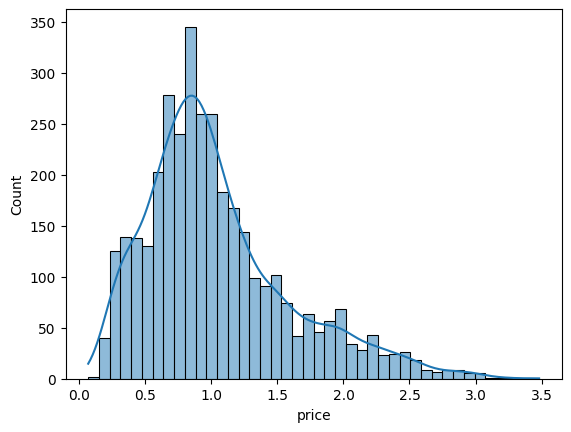

In [157]:
# Load the original target variable
with open('../models/xgboost_y_transformed.pkl', 'rb') as file:
    loaded_y = pickle.load(file)
    
sns.histplot(loaded_y,kde= True)

In [118]:
# Create a sample input
data = [['house', 'sector 102', 4, 3, '3+', 'New Property', 2750, 0, 0, 'unfurnished', 'Low', 'Low Floor']]
columns = ['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category']

# Convert to DataFrame
new_data = pd.DataFrame(data, columns=columns)

print("Sample input:")
new_data


Sample input:


,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,house,sector 102,4,3,3+,New Property,2750,0,0,unfurnished,Low,Low Floor


In [148]:
# Now you can use the loaded_pipeline for predictions
new_predictions = loaded_pipeline.predict(new_data)

# model is giving prediction in log space , we need to transform it to get back in original space
np.expm1(new_predictions)

array([2.830209], dtype=float32)

---
## **Use this as WebService**

``` from fastapi import FastAPI, Request
import pandas as pd
import numpy as np
import pickle
import uvicorn

app = FastAPI()

# Load the fitted pipeline
with open('../models/xgboost_pipeline_fitted.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

@app.post('/predict')
async def predict(request: Request):
    # Get the input data from the request
    input_data = await request.json()

    # Convert input data to DataFrame
    columns = ['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
               'agePossession', 'built_up_area', 'servant room', 'store room',
               'furnishing_type', 'luxury_category', 'floor_category']
    new_data = pd.DataFrame([input_data], columns=columns)

    # Make prediction
    prediction = loaded_pipeline.predict(new_data)

    # Since we used log1p transformation on the target variable, we need to use expm1 to get back to the original scale
    final_prediction = np.expm1(prediction)

    # Return the prediction as a JSON response
    return {'predicted_price': f"{final_prediction[0]:.2f} crores"}

if __name__ == '__main__':
    uvicorn.run(app, host='0.0.0.0', port=8000, debug=True)```

**END**

---